# Phase 6: Feature Engineering
## Multi-Campus Education Data Pipeline
This performs advanced feature engineering, aggregation, and risk flag generation for student academic performance analytics.

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
print("Libraries loaded")

Libraries loaded


## Step 2: Load Gold Reduced Dataset

In [2]:
# Load dataset
gold_df = pd.read_csv("Outputs/gold_reduced.csv")

print("Dataset shape:", gold_df.shape)
gold_df.head()

Dataset shape: (56896, 38)


,Student_ID,Full_Name,Gender,DOB,Campus_ID,Campus_Name,Program,Level,Intake_Year,Course_Code,Course_Title,Credits,Assessment_Type,Mark,Grade,Assessment_Date,Academic_Year,Semester,Attendance_Rate,Attendance_Rate_Scaled,Campus_Rwanda Polytechnic Huye,Campus_Rwanda Polytechnic Kigali,Campus_Rwanda Polytechnic Musanze,Assessment_Assignment,Assessment_Cat,Assessment_Final Exam,Assessment_Final Project,Assessment_Quiz,Performance_Band,Performance_Band_Numeric,Attendance_Category,Enrollment_Date,Program_Civil Engineering,Program_Computer Science,Program_Electronics,Program_Information Technology,Program_Mechanical Engineering,Program_Software Engineering
0,RPM20240030,Eric Niyonzima,Unknown,2006-11-02,RPM,Rwanda Polytechnic Musanze,Software Engineering,Level 4,2024,PHY101,Physics for Engineers,4.0,Final Project,65.0,B,2025-06-09,2025/2026,Semester 1,80.007887,-0.000743,False,False,True,False,False,False,True,False,Credit,3,Good,2025-06-07,False,False,False,False,False,True
1,RPM20230058,Sarah Habimana,Male,1999-01-14,RPM,Rwanda Polytechnic Musanze,Civil Engineering,Level 5,2023,CS201,Database Systems,4.0,Assignment,65.0,B,2025-09-12,2025/2026,Semester 1,80.007887,-0.000743,False,False,True,True,False,False,False,False,Credit,3,Good,2025-07-22,True,False,False,False,False,False
2,RPH20240367,Emmanuel Ntawukuriryayo,Male,1999-03-17,RPH,Rwanda Polytechnic Huye,Computer Science,Level 5,2024,CS102,Data Structures,5.0,Cat,65.0,B,2025-09-12,2023/2024,Semester 2,96.300000,1.484835,True,False,False,False,True,False,False,False,Credit,3,Excellent,2025-08-15,False,True,False,False,False,False
3,RPM20241489,Patrick Mugisha,Male,2000-06-19,RPM,Rwanda Polytechnic Musanze,Computer Science,Level 6,2024,CS101,Introduction to Programming,4.0,Cat,65.0,B,2025-09-12,2024/2025,Semester 2,70.300000,-0.885946,False,False,True,False,True,False,False,False,Credit,3,Good,2025-10-07,False,True,False,False,False,False
4,RPM20231482,Marie Habimana,Male,2004-11-17,RPM,Rwanda Polytechnic Musanze,Mechanical Engineering,Level 5,2023,MTH101,Calculus I,4.0,Quiz,65.0,B,2025-06-10,2025/2026,Semester 2,82.900000,0.262971,False,False,True,False,False,False,False,True,Credit,3,Good,2025-12-24,False,False,False,False,True,False


## Step 3: Date-Time Feature Engineering

In [3]:
gold_features = gold_df.copy()

# Convert assessment date
gold_features['Enrollment_Date'] = pd.to_datetime(
    gold_features['Enrollment_Date'], errors='coerce'
)

gold_features['assessment_month'] = gold_features['Enrollment_Date'].dt.month
gold_features['assessment_weekday'] = gold_features['Enrollment_Date'].dt.weekday
gold_features['is_weekend_assessment'] = np.where(
    gold_features['assessment_weekday'] >= 5, 1, 0
)

print("Date-time features created")

Date-time features created


## Step 4: Student Performance Aggregation

In [4]:
# Ensure numeric
gold_features['Mark'] = pd.to_numeric(gold_features['Mark'], errors='coerce')
gold_features['Credits'] = pd.to_numeric(gold_features['Credits'], errors='coerce')
gold_features['Attendance_Rate'] = pd.to_numeric(gold_features['Attendance_Rate'], errors='coerce')

# Pass/Fail flag
gold_features['is_fail'] = np.where(gold_features['Mark'] < 50, 1, 0)
gold_features['credits_earned'] = np.where(gold_features['Mark'] >= 50, gold_features['Credits'], 0)

# Aggregate per student
student_agg = gold_features.groupby('Student_ID').agg(
    student_course_count=('Course_Code', 'count'),
    student_avg_mark=('Mark', 'mean'),
    student_max_mark=('Mark', 'max'),
    student_fail_count=('is_fail', 'sum'),
    student_total_credits_earned=('credits_earned', 'sum')
).reset_index()

gold_features = gold_features.merge(student_agg, on='Student_ID', how='left')

print("Student aggregation features created")

Student aggregation features created


## Step 5: Risk Flag Engineering

In [5]:
AVG_MARK_THRESHOLD = 50
ATTENDANCE_THRESHOLD = 60

gold_features['low_attendance_flag'] = np.where(
    gold_features['Attendance_Rate'] < ATTENDANCE_THRESHOLD, 1, 0
)

gold_features['is_at_risk'] = np.where(
    (gold_features['student_avg_mark'] < AVG_MARK_THRESHOLD) |
    (gold_features['student_fail_count'] >= 2),
    1, 0
)

print("Risk features created")

Risk features created


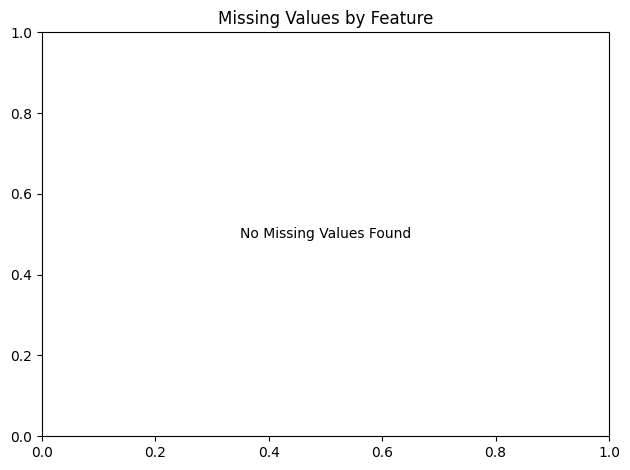

In [6]:
missing = gold_features.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure()

if len(missing) > 0:
    missing.plot(kind='bar')
    plt.title("Missing Values by Feature")
    plt.xlabel("Features")
    plt.ylabel("Count")
else:
    plt.text(0.5, 0.5, "No Missing Values Found", 
             horizontalalignment='center', 
             verticalalignment='center')
    plt.title("Missing Values by Feature")

plt.tight_layout()
plt.show()

## Step 7: Feature Summary

In [7]:

print("Total columns:", len(gold_features.columns))
print("Engineered Features:")
engineered_cols = [
    'Age','Academic_Year_Num','Avg_Mark','Max_Mark','Min_Mark',
    'Course_Count','Avg_Attendance','GPA','Pass_Rate',
    'Low_Attendance_Flag','Low_Performance_Flag','Risk_Score','At_Risk'
]

print(engineered_cols)


Total columns: 50
Engineered Features:
['Age', 'Academic_Year_Num', 'Avg_Mark', 'Max_Mark', 'Min_Mark', 'Course_Count', 'Avg_Attendance', 'GPA', 'Pass_Rate', 'Low_Attendance_Flag', 'Low_Performance_Flag', 'Risk_Score', 'At_Risk']


## Step 8: Visualization

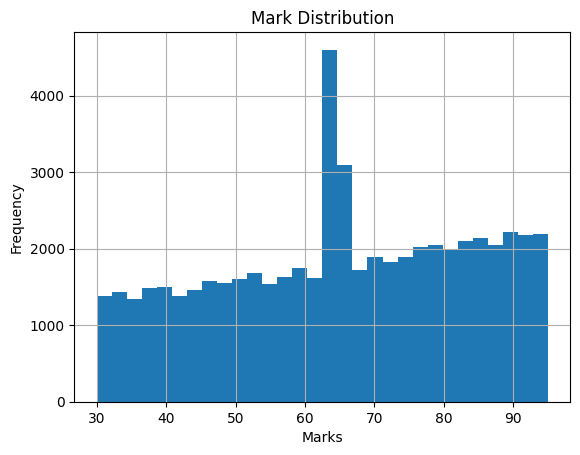

In [8]:

# Mark distribution
plt.figure()
gold_features['Mark'].hist(bins=30)
plt.title("Mark Distribution")
plt.xlabel("Marks")
plt.ylabel("Frequency")
plt.show()

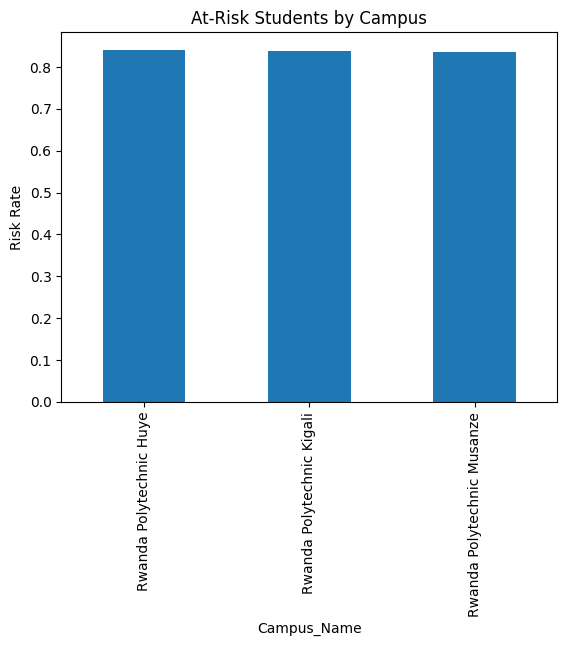

In [9]:

# At-risk students by campus
risk_by_campus = gold_features.groupby('Campus_Name')['is_at_risk'].mean()

plt.figure()
risk_by_campus.plot(kind='bar')
plt.title("At-Risk Students by Campus")
plt.ylabel("Risk Rate")
plt.show()



VISUALIZATION 1: MISSING VALUES ANALYSIS
 No missing values in the final dataset!


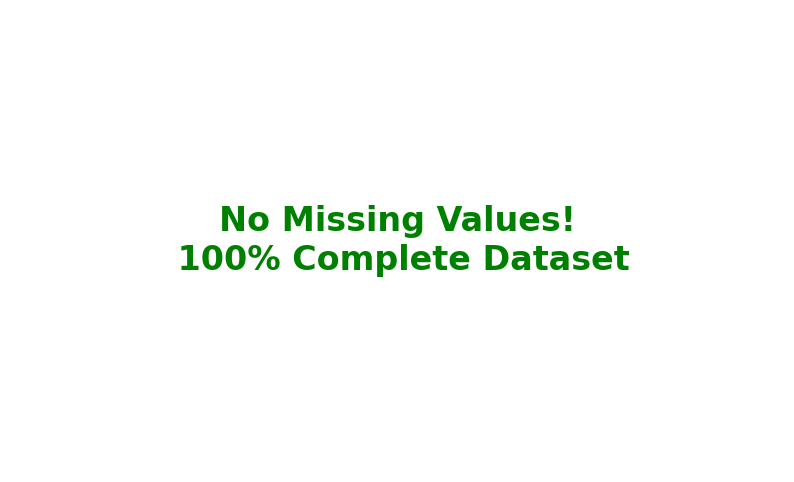

 Chart saved: Outputs/chart1_missing_values.png


In [10]:
print("\n" + "="*70)
print("VISUALIZATION 1: MISSING VALUES ANALYSIS")
print("="*70)

# Calculate missing values
missing_counts = gold_features.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

if len(missing_counts) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.barh(range(len(missing_counts)), missing_counts.values, color='coral', edgecolor='black')
    ax.set_yticks(range(len(missing_counts)))
    ax.set_yticklabels(missing_counts.index)
    ax.set_xlabel('Number of Missing Values', fontsize=12)
    ax.set_title('Missing Values by Column (Final Dataset)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, val) in enumerate(missing_counts.items()):
        pct = (val / len(gold_features)) * 100
        ax.text(val + len(gold_features)*0.01, i, f'{val} ({pct:.1f}%)', 
               va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('Outputs/chart1_missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f" Chart saved: Outputs/chart1_missing_values.png")
else:
    print(" No missing values in the final dataset!")
    
    # Create a celebratory chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.text(0.5, 0.5, 'No Missing Values!\n 100% Complete Dataset', 
           ha='center', va='center', fontsize=24, fontweight='bold', color='green')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.savefig('Outputs/chart1_missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f" Chart saved: Outputs/chart1_missing_values.png")


VISUALIZATION 2: MARK DISTRIBUTION ANALYSIS


C:\Users\pc\AppData\Local\Temp\ipykernel_12932\95470892.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(program_data, labels=programs, patch_artist=True)


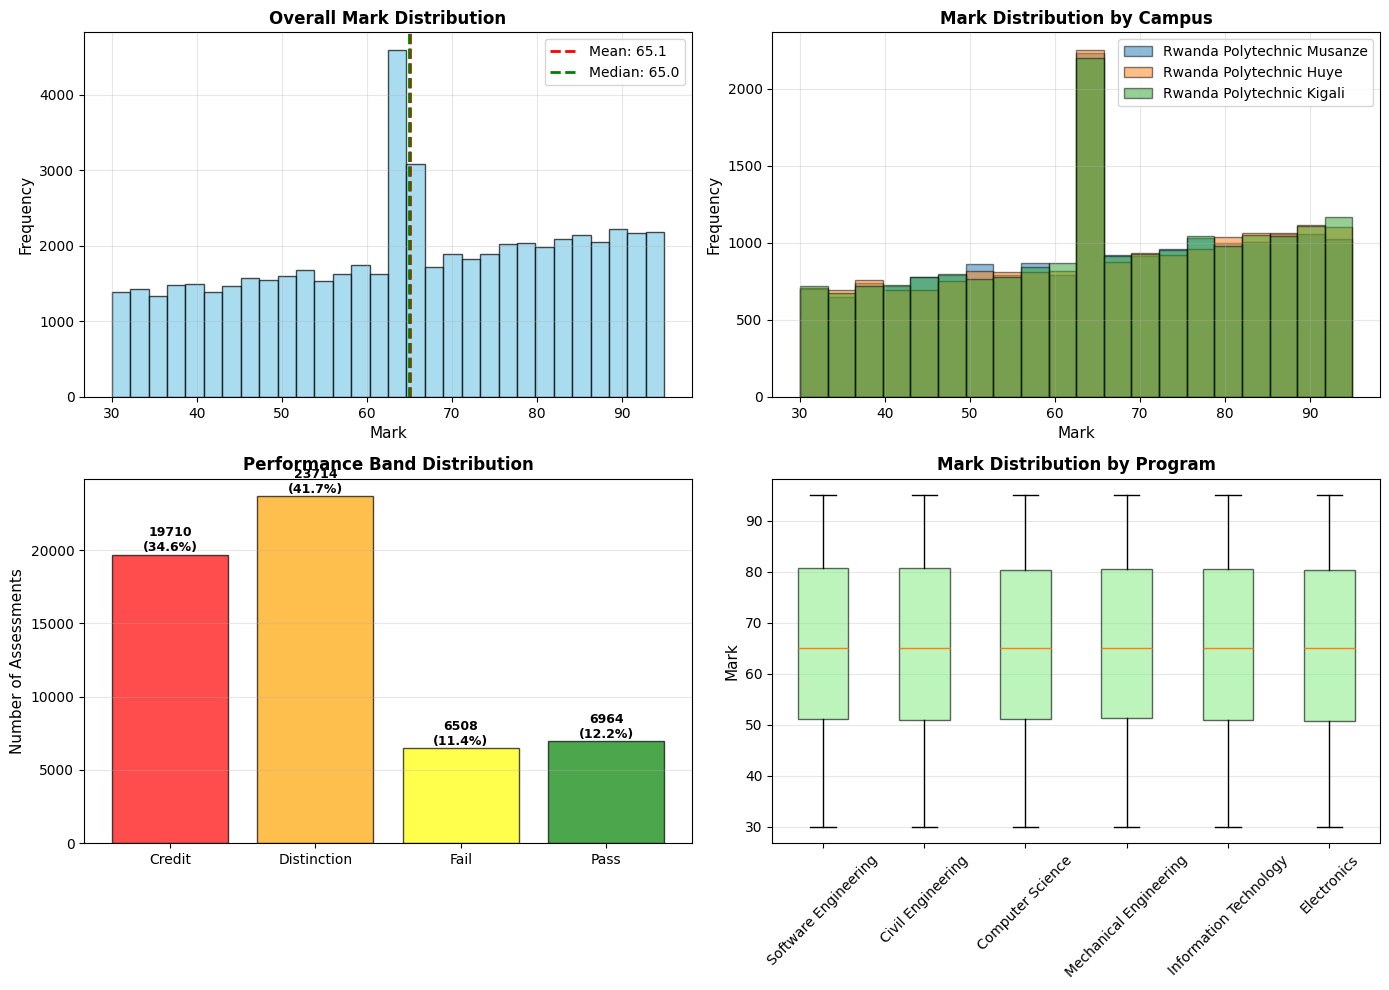

 Chart saved: Outputs/chart2_mark_distribution.png


In [11]:
print("\n" + "="*70)
print("VISUALIZATION 2: MARK DISTRIBUTION ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall Mark Distribution
axes[0, 0].hist(gold_features['Mark'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(gold_features['Mark'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {gold_features['Mark'].mean():.1f}")
axes[0, 0].axvline(gold_features['Mark'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: {gold_features['Mark'].median():.1f}")
axes[0, 0].set_xlabel('Mark', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Overall Mark Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Mark Distribution by Campus
for campus in gold_features['Campus_Name'].unique():
    campus_data = gold_features[gold_features['Campus_Name'] == campus]['Mark']
    axes[0, 1].hist(campus_data, bins=20, alpha=0.5, label=campus, edgecolor='black')
axes[0, 1].set_xlabel('Mark', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Mark Distribution by Campus', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Performance Band Distribution
performance_counts = gold_features['Performance_Band'].value_counts().sort_index()
colors_perf = ['red', 'orange', 'yellow', 'green']
bars = axes[1, 0].bar(range(len(performance_counts)), performance_counts.values, 
                      color=colors_perf, edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(performance_counts)))
axes[1, 0].set_xticklabels(performance_counts.index, rotation=0)
axes[1, 0].set_ylabel('Number of Assessments', fontsize=11)
axes[1, 0].set_title('Performance Band Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, performance_counts.values)):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, height + 20, 
                   f'{val}\n({val/len(gold_features)*100:.1f}%)', 
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Box Plot by Program
programs = gold_features['Program'].unique()
program_data = [gold_features[gold_features['Program'] == prog]['Mark'].dropna() for prog in programs]
bp = axes[1, 1].boxplot(program_data, labels=programs, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
    patch.set_alpha(0.6)
axes[1, 1].set_ylabel('Mark', fontsize=11)
axes[1, 1].set_title('Mark Distribution by Program', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('Outputs/chart2_mark_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Chart saved: Outputs/chart2_mark_distribution.png")


VISUALIZATION 3: AT-RISK STUDENTS ANALYSIS


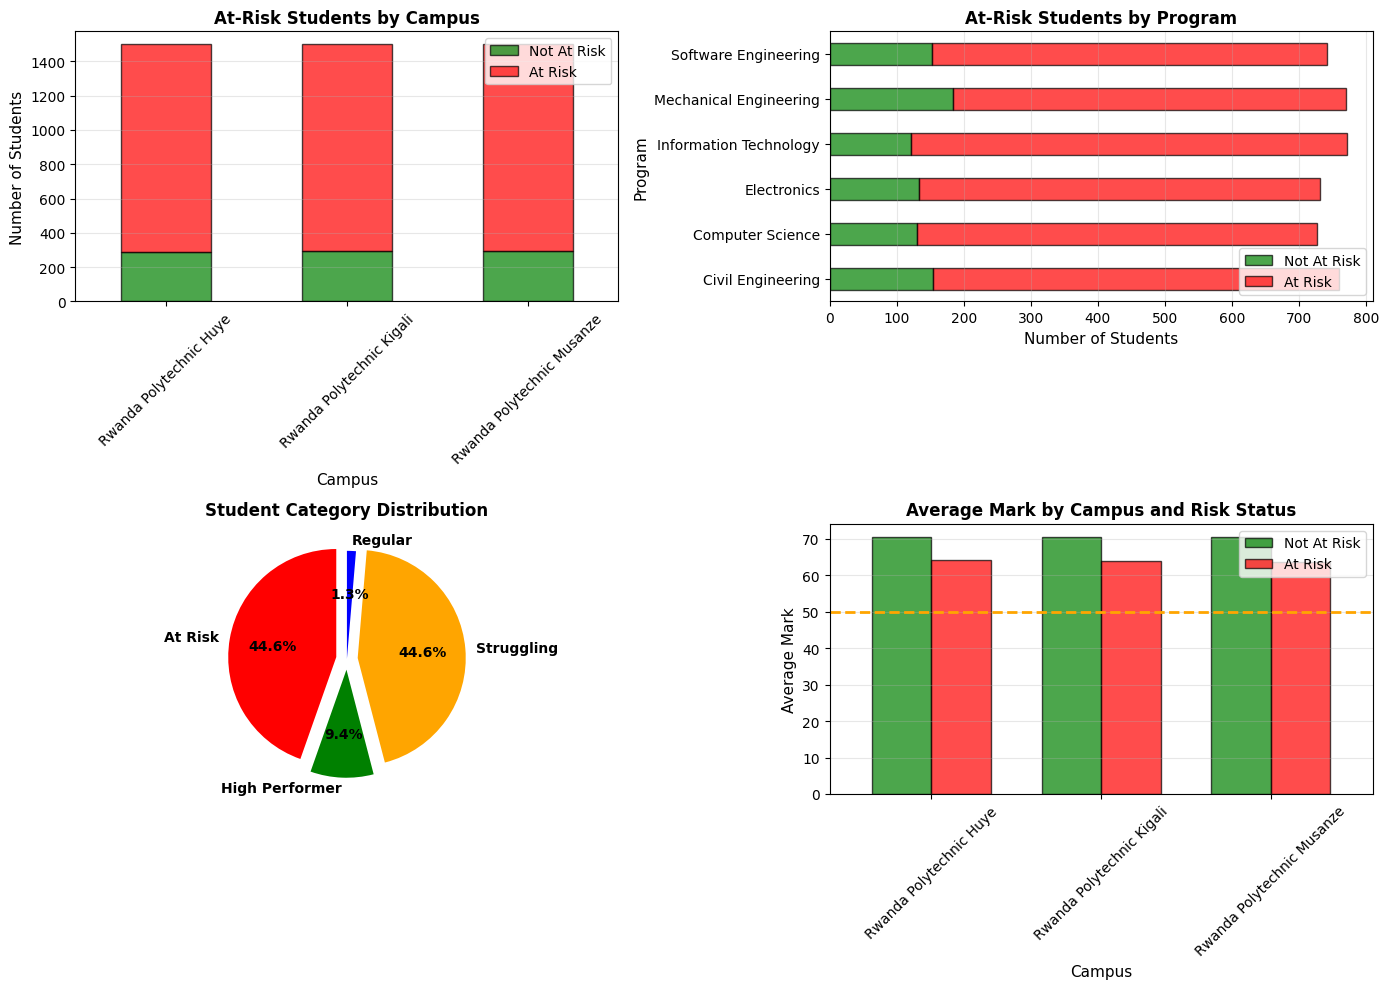

 Chart saved: Outputs/chart3_at_risk_analysis.png

At-Risk Analysis Summary:
  Rwanda Polytechnic Huye: 1212/1500 at-risk (80.8%)
  Rwanda Polytechnic Kigali: 1208/1500 at-risk (80.5%)
  Rwanda Polytechnic Musanze: 1204/1500 at-risk (80.3%)


In [12]:
print("\n" + "="*70)
print("VISUALIZATION 3: AT-RISK STUDENTS ANALYSIS")
print("="*70)

# -------------------------------------------------
#  ENSURE REQUIRED COLUMNS EXIST
# -------------------------------------------------

# High Performer: strong academic average
if 'high_performer' not in gold_features.columns:
    gold_features['high_performer'] = (gold_features['student_avg_mark'] >= 70).astype(int)

# Struggling Student: low average OR many fails
if 'struggling_student' not in gold_features.columns:
    gold_features['struggling_student'] = (
        (gold_features['student_avg_mark'] < 50) |
        (gold_features['student_fail_count'] >= 2)
    ).astype(int)


# -------------------------------------------------
#  CREATE STUDENT-LEVEL SUMMARY
# -------------------------------------------------

student_summary = gold_features.groupby('Student_ID').agg({
    'Campus_Name': 'first',
    'Program': 'first',
    'is_at_risk': 'max',
    'student_avg_mark': 'first',
    'student_fail_count': 'first',
    'high_performer': 'max',
    'struggling_student': 'max'
}).reset_index()


# -------------------------------------------------
# CREATE VISUALIZATION
# -------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. At-Risk Students by Campus
risk_by_campus = student_summary.groupby(['Campus_Name', 'is_at_risk']).size().unstack(fill_value=0)

risk_by_campus.plot(
    kind='bar',
    stacked=True,
    ax=axes[0, 0],
    color=['green', 'red'],
    alpha=0.7,
    edgecolor='black'
)

axes[0, 0].set_xlabel('Campus', fontsize=11)
axes[0, 0].set_ylabel('Number of Students', fontsize=11)
axes[0, 0].set_title('At-Risk Students by Campus', fontsize=12, fontweight='bold')
axes[0, 0].legend(['Not At Risk', 'At Risk'], loc='upper right')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)


# 2. At-Risk Students by Program
risk_by_program = student_summary.groupby(['Program', 'is_at_risk']).size().unstack(fill_value=0)

risk_by_program.plot(
    kind='barh',
    stacked=True,
    ax=axes[0, 1],
    color=['green', 'red'],
    alpha=0.7,
    edgecolor='black'
)

axes[0, 1].set_xlabel('Number of Students', fontsize=11)
axes[0, 1].set_ylabel('Program', fontsize=11)
axes[0, 1].set_title('At-Risk Students by Program', fontsize=12, fontweight='bold')
axes[0, 1].legend(['Not At Risk', 'At Risk'], loc='lower right')
axes[0, 1].grid(axis='x', alpha=0.3)


# 3. Student Category Distribution (Pie Chart)
categories = ['At Risk', 'High Performer', 'Struggling', 'Regular']

counts = [
    student_summary['is_at_risk'].sum(),
    student_summary['high_performer'].sum(),
    student_summary['struggling_student'].sum(),
    len(student_summary)
    - student_summary['is_at_risk'].sum()
    - student_summary['high_performer'].sum()
]

colors_cat = ['red', 'green', 'orange', 'blue']
explode = (0.1, 0.1, 0.1, 0)

axes[1, 0].pie(
    counts,
    labels=categories,
    autopct='%1.1f%%',
    colors=colors_cat,
    explode=explode,
    startangle=90,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)

axes[1, 0].set_title('Student Category Distribution', fontsize=12, fontweight='bold')


# 4. Average Mark by Campus and Risk Status
avg_mark_analysis = student_summary.groupby(['Campus_Name', 'is_at_risk'])['student_avg_mark'].mean().unstack()

avg_mark_analysis.plot(
    kind='bar',
    ax=axes[1, 1],
    color=['green', 'red'],
    alpha=0.7,
    edgecolor='black',
    width=0.7
)

axes[1, 1].set_xlabel('Campus', fontsize=11)
axes[1, 1].set_ylabel('Average Mark', fontsize=11)
axes[1, 1].set_title('Average Mark by Campus and Risk Status', fontsize=12, fontweight='bold')
axes[1, 1].legend(['Not At Risk', 'At Risk'])
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# At-risk threshold line
axes[1, 1].axhline(y=50, color='orange', linestyle='--', linewidth=2, label='At-Risk Threshold')


# -------------------------------------------------
#  SAVE & SHOW
# -------------------------------------------------

plt.tight_layout()
plt.savefig('Outputs/chart3_at_risk_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Chart saved: Outputs/chart3_at_risk_analysis.png")


# -------------------------------------------------
#  PRINT SUMMARY STATISTICS
# -------------------------------------------------

print("\nAt-Risk Analysis Summary:")

for campus in student_summary['Campus_Name'].unique():
    campus_students = student_summary[student_summary['Campus_Name'] == campus]
    at_risk = campus_students['is_at_risk'].sum()
    total = len(campus_students)

    percent = (at_risk / total * 100) if total > 0 else 0

    print(f"  {campus}: {at_risk}/{total} at-risk ({percent:.1f}%)")


## Step 9: Save Final Gold Features Dataset

In [13]:
gold_features.to_csv("Outputs/gold_features.csv", index=False)

print("Saved successfully")
print("Final dataset shape:", gold_features.shape)
print("Total columns:", len(gold_features.columns))

print(f"  At-Risk Students: {student_summary['is_at_risk'].sum()}")
print(f"  High Performers: {student_summary['high_performer'].sum()}")

print("\nCharts generated (if created earlier):")
print("   Outputs/chart1_missing_values.png")
print("   Outputs/chart2_mark_distribution.png")
print("   Outputs/chart3_at_risk_analysis.png")

print("\n" + "="*70)
print("ALL PHASES COMPLETED - READY FOR ANALYSIS AND ML!")
print("="*70)

Saved successfully
Final dataset shape: (56896, 52)
Total columns: 52
  At-Risk Students: 3624
  High Performers: 767

Charts generated (if created earlier):
   Outputs/chart1_missing_values.png
   Outputs/chart2_mark_distribution.png
   Outputs/chart3_at_risk_analysis.png

ALL PHASES COMPLETED - READY FOR ANALYSIS AND ML!
